## [모듈 2.3] 모델 배포 및 추론
Using Scikit-learn with the SageMaker Python SDK
- https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html

Iris Training and Prediction with Sagemaker Scikit-learn
- https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_iris/scikit_learn_estimator_example_with_batch_transform.ipynb

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


In [12]:
%store -r test_file_path
%store -r s3_model_dir
%store -r local_model_dir

In [13]:
df = pd.read_csv(test_file_path, header=None)
df = df.astype('float64')
test_y = df.iloc[:,0]
test_X = df.iloc[:,1:].to_numpy()
print("test_X : ", test_X.shape)



test_X :  (149, 59)


## 파라미터: Local Mode or SageMaker Hosting Service

In [14]:
# instance_type = 'local'
instance_type="ml.c4.xlarge"

## 인퍼런스 코드 테스트

In [15]:
def input_fn(input_data, request_content_type='text/csv'):
    """
    """
    n_feature = input_data.shape[1]
    sample = input_data.reshape(-1,n_feature)
    return sample

# input for evaluation
sample = input_fn(test_X[0:10])

In [16]:
import src.inference
from importlib import reload
src.inference = reload(src.inference)

from src.inference import model_fn, predict_fn

model = model_fn('model')
predictons = predict_fn(sample, model)
print(predictons)

From user-inference file- Model loaded: 
From user-inference file- Shape of predictions:  (10,)
[9069.2651918  8982.41729444 9176.31755404 8994.60210337 9133.82113768
 9084.69360602 9137.61855237 9053.16578649 8991.09776216 8897.57764731]


In [17]:
import time
local_model_path = f'file://{os.getcwd()}/model/model.joblib'
endpoint_name = 'local-endpoint-scikit-learn-{}'.format(int(time.time()))

### Docker 명령어
로컬로드로 실행시에는 로컬에서 다커가 실행이 됩니다. 하지만 다커가 종료가 되지 않은 상태이면, 아래 명령어를 사용하여 다커를 중지 시키고 다시 실행합니다.

- 현재 실행중인 컨테이너를 보여주기
``` 
docker container ls
```
- 현재 실행중인 컨테이너를 모두 정지 시키기
```
docker stop $(docker ps -a -q)
```


requirements.txt 
- 인퍼런스시에 추가 패키지 설치

In [18]:
import sagemaker
from sagemaker import local

if instance_type == 'local':
    sess = local.LocalSession()
    model_path = local_model_path
else:
    sess = sagemaker.Session()
    model_path = s3_model_dir

In [19]:
from sagemaker import get_execution_role

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

FRAMEWORK_VERSION = "0.23-1"

from sagemaker.sklearn.model import SKLearnModel
sm_model = SKLearnModel(model_data = model_path,
                           role = role,
                           source_dir = 'src',
                           entry_point = 'inference.py',
                           framework_version = FRAMEWORK_VERSION,
                           py_version = 'py3',
                           sagemaker_session = sess
                           
                          )



## 모델 배포 및 추론

In [20]:
%%time

predictor = sm_model.deploy(
    initial_instance_count=1,
    instance_type= instance_type,
    endpoint_name = endpoint_name,
    wait=True
    )

-------------!

In [21]:
sample = input_fn(test_X)
ridge_pred = predictor.predict(sample)


In [22]:
import p_utils
from importlib import reload
p_utils = reload(p_utils)


from p_utils import evaluate, show_chart

Ridge-onestep-ahead MdAPE =  0.021827676341313194


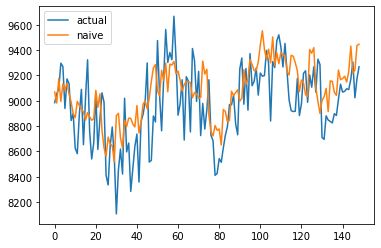

In [23]:
# Predict
# ridge_pred = predict_fn(sample, model_ridge)
# lasso_pred = predict_fn(model_lasso, sample)

# Evaluate
MdAPE = evaluate(test_y, ridge_pred)
print('Ridge-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, ridge_pred) 

## Endpoint Cleanup

In [24]:
predictor.delete_endpoint()